In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import keras
import numpy as np

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [ ]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
import cv2
import pathlib
import random

In [ ]:
#train
train = []
train_target = []

#test
test = []
test_target = []

#validation
valid = []
valid_target = []

In [ ]:
count = 0
datapath = "../input/face-mask-12k-images-dataset/Face Mask Dataset"
for i in os.listdir(datapath):
    #path = os.path.join("../input/face-mask-12k-images-dataset/Face Mask Dataset",i)
    
    for img_nm in os.listdir(os.path.join(datapath,i,"WithMask")):
        imgpath = os.path.join(datapath,i,"WithMask",img_nm)
        img = cv2.imread(imgpath)
        
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
        gray = cv2.resize(img,(128,128))
        
        if count == 0:
            valid.append(gray)
            valid_target.append(0)
        
        if count == 1:
            test.append(gray)
            test_target.append(0)
        
        if count == 2:
            train.append(gray)
            train_target.append(0)
        
    for img_nm in os.listdir(os.path.join(datapath,i,"WithoutMask")):
        imgpath = os.path.join(datapath,i,"WithoutMask",img_nm)
        img = cv2.imread(imgpath)
        
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
        gray = cv2.resize(img,(128,128))
        
        if count == 0:
            valid.append(gray)
            valid_target.append(1)
        
        if count == 1:
            test.append(gray)
            test_target.append(1)
        
        if count == 2:
            train.append(gray)
            train_target.append(1)
            
    count = count + 1    
    

In [ ]:
train = np.array(train)/255.0
train = np.reshape(train,(train.shape[0],128,128,3))
train_target = np.array(train_target)
train_target = np_utils.to_categorical(train_target)

test = np.array(test)/255.0
test = np.reshape(test,(test.shape[0],128,128,3))
test_target = np.array(test_target)
test_target = np_utils.to_categorical(test_target)

valid = np.array(valid)/255.0
valid = np.reshape(valid,(valid.shape[0],128,128,3))
valid_target = np.array(valid_target)
valid_target = np_utils.to_categorical(valid_target)

In [ ]:
valid.shape

(800, 128, 128, 3)

In [ ]:
from keras.applications import ResNet50

In [ ]:
weights_path = "../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
resnet = ResNet50(weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape = (128, 128, 3))
#resnet.trainable = False

In [ ]:
resnet.trainable = False

In [ ]:
def build(resnet):
    input_data = Input(shape=(128, 128, 3))
    x = resnet(input_data)
    x = GlobalMaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128,activation='relu')(x) 
    output = Dense(2, activation='sigmoid')(x)
    
    resnet_model = Model(inputs=input_data, outputs=output)    
    return resnet_model

In [ ]:
model_res = Sequential([
    resnet,
    GlobalMaxPooling2D()
    BatchNormalization()
    Dropout(0.3)
    Dense(128,activation='relu')
    Dense(2, activation='sigmoid')
])

In [ ]:
model_res.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_res.summary()

In [ ]:
model = build(resnet)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258 

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)]
history = model.fit(train, train_target,
                         epochs = 15,
                         verbose = 1,
                         batch_size=32,
                         validation_data = (valid, valid_target),
                         callbacks=callbacks)

Epoch 1/15
313/313 [==============================] - 340s 1s/step - loss: 0.4145 - accuracy: 0.8067 - val_loss: 0.3924 - val_accuracy: 0.7937
Epoch 2/15
313/313 [==============================] - 336s 1s/step - loss: 0.2804 - accuracy: 0.8852 - val_loss: 0.2171 - val_accuracy: 0.9137
Epoch 3/15
313/313 [==============================] - 340s 1s/step - loss: 0.2463 - accuracy: 0.8953 - val_loss: 0.2241 - val_accuracy: 0.9162
Epoch 4/15
313/313 [==============================] - 340s 1s/step - loss: 0.2245 - accuracy: 0.9071 - val_loss: 0.2026 - val_accuracy: 0.9275
Epoch 5/15
313/313 [==============================] - 338s 1s/step - loss: 0.2245 - accuracy: 0.9062 - val_loss: 0.1817 - val_accuracy: 0.9350
Epoch 6/15
313/313 [==============================] - 337s 1s/step - loss: 0.2102 - accuracy: 0.9130 - val_loss: 0.1817 - val_accuracy: 0.9362
Epoch 7/15
313/313 [==============================] - 336s 1s/step - loss: 0.1915 - accuracy: 0.9237 - val_loss: 0.1795 - val_accuracy: 0.9425

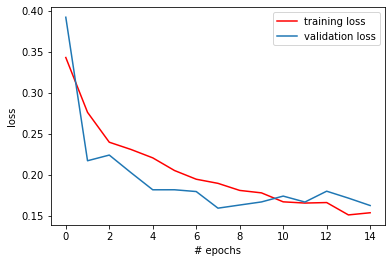

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

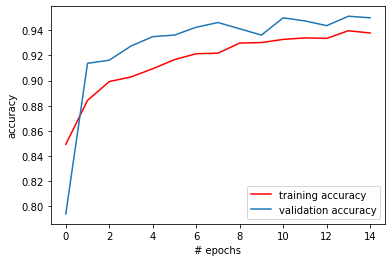

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate(test,test_target))

31/31 [==============================] - 31s 990ms/step - loss: 0.1547 - accuracy: 0.9466
[0.1546512246131897, 0.9465726017951965]


In [ ]:
model.save("resnet_kaggle.h5")